In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation,rc
from IPython.display import HTML
rc('animation', html='html5')

In [12]:
#General Supporting Function

def p(x):
    return 1

def q(x):
    return 1

# Heat Equation Supporting Functions

def Heat_Equation_f(x,t):
    """
    input:
    x: Grid Point
    t: time
    output:
    expression for f
    """
    return np.sin(np.pi*x)*(np.power(np.pi,2)*np.cos(t) - np.sin(t))

def Analytical_Heat_Equation_solution(x,t):
    """
    input:
    x: Grid Point
    t: time
    output:
    Analytical Solution of heat Equation
    """
    return np.sin(np.pi*x)*np.cos(t)

def Boundary_Condition(x):
    return np.sin(np.pi*x)

# Burger's Equation Supporting Functions

def Analytical_Burgers_Equation_solution(x,t):
    """
    input:
    x: Grid Point
    t: time
    output:
    Analytical Solution of Burger's Equation
    """
    return np.exp(-t)*np.sin(np.pi*x)

def Burger_Equation_f(x,t):
    """
    input:
    x: Grid Point
    t: time
    output:
    expression for f
    """
    return np.exp(-t)*np.sin(np.pi*x)*(np.pi*np.exp(-t)*np.cos(np.pi*x) + np.power(np.pi,2) -1)

# Allen-Cahn Supporting Functions

def Boundary_Condition_2(x):
    """
    input: 
    x: Grid Point
    Output: 
    Return an array of x.size contianing Random Noise between 4 and -4
    """
    np.random.seed(seed=10)
    n = x.shape[0]
    a = -4
    b = 4
    Noise = (b - a) * np.random.random(n) + a
    return Noise

#This code has been taken from https://github.com/christian512/SemiLagPy

def Animation(data,xlim,ylim):
    """
    input: Data or value of advections at each time step
    xlim: (Inital value,final value) of x-axis for animation window
    ylim: (Inital value,final value) of y-axis for animation window
    output: Return the animation function
    """

    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure()
    ax = plt.axes(xlim=(xlim[0], xlim[1]), ylim=(ylim[0], ylim[1]))
    line, = ax.plot([], lw=2)
    ax.set_xlabel('x')
    ax.set_ylabel('Function Value')

    # initialization function: plot the background of each frame
    def init():
        line.set_data([],[])
        return line,

    # animation function.  This is called sequentially
    def animate(i):
        F = data[i,:]
        x = np.linspace(0,1,F.shape[0])
        line.set_data(x,F)
        return line,

    # create animation
    Nt = data.shape[0]
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=Nt, interval=20, blit=False)
    return anim


#Code to plot true and calculated solution for different t

def PLOT(Time_index,C,Analytical_solution_handel,name,title):
    """
    input:
    Time_index =  Time_Index elements = [First_value,second_value], where first value is the index where t=second_value occur matrix C
    C : Caculated Coefficient 
    Analytical_solution_handel :  Function handel for analytical solution
    name: Name with which you want to savefig
    title: Title for figure
    output: 
    plot true and calculated solution at different t
    
    """
    x = np.linspace(0,1,C.shape[1])
    plt.figure(figsize = (10,10))
    for index,time in Time_index:
        Analytical_solution = Analytical_solution_handel(x,time)
        plt.plot(x,C[int(index),:],label="t="+str(time)+"|"+" Calculated Solution",marker = 11,markersize=6)
        plt.plot(x,Analytical_solution,label="t="+str(time)+"|"+" Analytical Solution",marker = 'o',markersize=5)
    plt.xlabel("x")
    plt.ylabel("Function Value")
    plt.legend()
    plt.title(title)
    plt.savefig(name)

## To get Geometry

In [13]:
def geometry(Number_of_element):
    """
    Input  =  N(Number of Element)
    Output =  
    x_coord     : equispaced X point between 0,1
    Nodes       : Global Position of Nodes
    Quad_Point  : Quad Point Calculated by MID-POINT
    Quad_Weight : Weights W, Equispaced, X_1 - X_0
    """
    
    x_coord = [i/Number_of_element for i in range(Number_of_element+1)]
    Nodes = [(i,i-1,i) for i in range(1,Number_of_element+1)]
    Quad_Point  = [(x_coord[i] + x_coord[i-1])/2 for i in range(1,Number_of_element+1)]
    Quad_weight = [(x_coord[i] - x_coord[i-1]) for i in range(1,Number_of_element+1)]
    
    return x_coord,Nodes,Quad_Point,Quad_weight

## To get Linear Basis

In [14]:
def pw_linear_basis_function(x,n,x_coord):
    
    """
    Input   =
    x       : The Point where we need basis function value
    n       : The node point
    x_coord : equispaced X point between 0,1
    
    Output  = a tuple (value of basic function at x, Derivative of basic function at x)
    """
    
    h = 1/(len(x_coord)-1)
      
    if(x_coord[n-1] <= x and x < x_coord[n]):
        return (x - x_coord[n-1])/h, -1/h
    
    elif(x_coord[n] <= x and x < x_coord[n+1]):
        return (x_coord[n+1] - x)/h, 1/h
    
    else:
        return 0,0 

## To get Matrix M,S

In [15]:
def system_assembly(N,q,p):
    
    """
    INPUT:
    N :  Number of Nodes
    f :  Function handel for f(x)
    q,p: Function handel for q,p(The value of function for q,p=1 for this lab).
    
    Output:
    return Matrix M,S
    """
    #Intialize all the matrix
    M = np.zeros((N,N))
    S = np.zeros((N,N))
    h = 1/N
    #Get Geometry
    x_coord,Nodes,Quad_Point,Quad_weight = geometry(N)
    
    #Iterate over all interval
    for I in range(N):
        
        Bases  = Nodes[I][1:]     #Get Basis for given interval
        x_l    = Quad_Point[I]    #Get Quad Point given interval  
        w_l    = Quad_weight[I]   #Get Weight for given interval
        #Iterate over bases
        for i in Bases:
                if(i==N):         #Omit the Nth node, because matrix can handel the value upto N-1 index
                    continue
                #Iterate over bases  
                for j in Bases:
                    if(j!=N):        
                        M[i][j] = M[i][j] + q(x_l)*w_l*pw_linear_basis_function(x_l,i,x_coord)[0]*pw_linear_basis_function(x_l,j,x_coord)[0]

                        S[i][j] = S[i][j] + p(x_l)*w_l*pw_linear_basis_function(x_l,i,x_coord)[1]*pw_linear_basis_function(x_l,j,x_coord)[1]
     
    
    # Note :- I have omitted out the calculation for phi 0 and phi last nodes, since the value given at that point can be given
    #         by boundary condition (coeff = 0). 
    return M[1:N,1:N],S[1:N,1:N]

## Problem 1

In [16]:
def assemble_f(N,t,f):
    """
    INPUT:
    N :  Number of Nodes
    f :  Function handel for f(x)
    t :  time where F need to be computed.    
    Output:
    return Matrix F
    
    """
    #Intialize F
    F = np.zeros((N,1))
    #Get Geometry
    x_coord,Nodes,Quad_Point,Quad_weight = geometry(N)
    #Iterate over all interval
    for I in range(N):    
        Bases  = Nodes[I][1:]       #Get Basis for given interval
        x_l    = Quad_Point[I]      #Get Quad Point given interval
        w_l    = Quad_weight[I]     #Get Weight for given interval
        #Iterate over all Bases
        for i in Bases:
            if(i!=N):
                F[i] = F[i] + f(x_l,t)*w_l*pw_linear_basis_function(x_l,i,x_coord)[0]

    return F[1:N]

In [17]:
def Heat_Equation_solver(N,f,Boundary_Condition,dt,T,q,p):
    
    """
    INPUT:
    N :  Number of Nodes
    f :  Function handel for f(x)
    Boundary_Condition : Function handel for boundary condition
    dt : dt
    T : Total time
    q,p: Function handel for q,p(The value of function for q,p=1 for this lab).
    
    Output:
    return: Solution, the coefficent C at different t.
    
    """
    # Setup geometry
    x_coord,Nodes,Quad_Point,Quad_weight = geometry(N)
 
    # Get M and S
    M,S = system_assembly(N,q,p)
    
    #Set Matrix C
    Nt = int(T/dt)
    C = np.zeros((Nt+1,N+1))
    C[0,1:-1] = Boundary_Condition(np.array(x_coord[1:-1]))        #Assign initial Conditon
    
    #Holder for vector F
    F = np.zeros((N-1,1))
    n=1
    
    while(n*dt<=T):
        F = assemble_f(N,n*dt,f)                                 #Get Matrix F
        A = (M + dt*S)                                           #A = L.H.S of system of equation
        B = np.dot(M,C[n-1,1:-1].reshape(N-1,1)) + dt*F          #b = R.H.S of system of equation
        C[n,1:-1] = np.linalg.solve(A,B).T                       # Solver linear system
        n = n + 1                                                #Increase the count
    return C

In [18]:
dt = 0.1  
T = 8      
N = 64
C_heat_equation= Heat_Equation_solver(N,Heat_Equation_f,Boundary_Condition,dt,T,q,p)

In [19]:
C_heat_equation.shape

(81, 65)

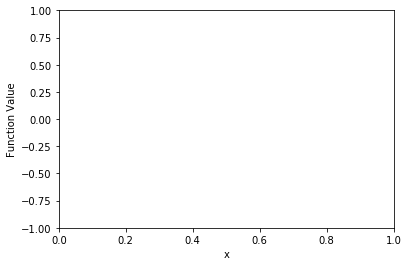

In [20]:
# Create the animation for result
xlim = [0,1]
ylim = [-1,1]
anim = Animation(C_heat_equation,xlim,ylim)
HTML(anim.to_html5_video())

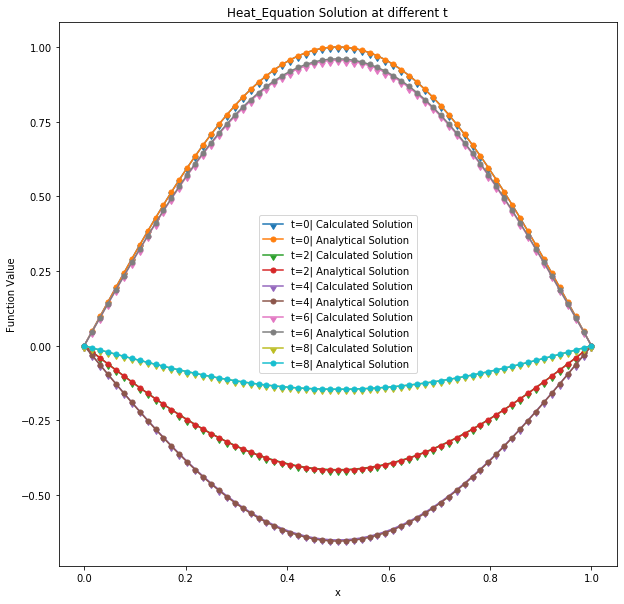

In [21]:
# Time_Index element = [First_value,second_value], where first value is the index where t=second_value occur in Solution C
Time_index = [[i*(C_heat_equation.shape[0]/4),(i)*2] for i in range(5)]  
Time_index[-1][0] = Time_index[-1][0]-1
PLOT(Time_index,C_heat_equation,Analytical_Heat_Equation_solution,"Heat_Equation","Heat_Equation Solution at different t")

## Problem 2

In [22]:
def Burger_assemble_b(N,c):
    """
    INPUT:
    N :  Number of Nodes
    c :  coefficent at time step n-1 
    Output:
    return vector b
    
    """
    #Holder for vector b
    b = np.zeros((N,1))
    # Get Geometry
    x_coord,Nodes,Quad_Point,Quad_weight = geometry(N)
    
    #Iterate over all Interval
    for I in range(N):
        
        Bases  = Nodes[I][1:]             #Get Basis for given interval
        x_l    = Quad_Point[I]            #Get Quad Point given interval
        w_l    = Quad_weight[I]           #Get Weight for given interval
        
        UnMinusOne = 0
        UnMinusOneX = 0
        #Iterate over Bases
        for i in Bases:
            if(i!=N):
                UnMinusOne = UnMinusOne + c[i]*pw_linear_basis_function(x_l,i,x_coord)[0]
                UnMinusOneX = UnMinusOneX + c[i]*pw_linear_basis_function(x_l,i,x_coord)[1]
        #Iterate over Bases
        for i in Bases:
            if(i!=N):
                b[i] = b[i] + UnMinusOne*UnMinusOneX*pw_linear_basis_function(x_l,i,x_coord)[0]*w_l
    return b[1:N]    

In [23]:
def Burger_Equation_solver(N,f,Boundary_Condition,dt,T,q,p): 
    """
    INPUT:
    N :  Number of Nodes
    f :  Function handel for f(x)
    Boundary_Condition : Function handel for boundary condition, (Same one used in Heat equation)
    dt : dt
    T : Total time
    q,p: Function handel for q,p(The value of function for q,p=1 for this lab).
    
    Output:
    return: Solution, the coefficent C at different t.
    
    """
    
    # Setup geometry
    x_coord,Nodes,Quad_Point,Quad_weight = geometry(N)
 
    # Get M and S
    M,S = system_assembly(N,q,p)
    
    #Set Matrix C
    Nt = int(T/dt)
    C = np.zeros((Nt+1,N+1))
    C[0,1:-1] = Boundary_Condition(np.array(x_coord[1:-1]))   #Assign initial Conditon
    
    # Holder for vector f
    F = np.zeros((N-1,1))
    
    n=1
    while(n*dt<=T):
        F = assemble_f(N,n*dt,f)                #Same as used in Heat Equation
        b = Burger_assemble_b(N,C[n-1,:])       #Get vector b       
        A = (M + dt*S)                          # L.H.S of AX=B
        B = np.dot(M,C[n-1,1:-1].reshape(-1,1)) + dt*F - dt*b  # R.H.S of AX=B
        C[n,1:-1] = np.linalg.solve(A,B).T      #Solve the linear system   
        n = n + 1
    return C                                    #Return Solution

In [24]:
dt = 0.1
T = 8
N = 64
C_Burger_Equation = Burger_Equation_solver(N,Burger_Equation_f,Boundary_Condition,dt,T,q,p)

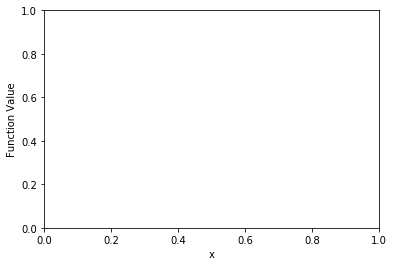

In [25]:
# Create the animation for result
xlim = [0,1]
ylim = [0,1]
anim = Animation(C_Burger_Equation,xlim,ylim)
HTML(anim.to_html5_video())

#### Code to plot true and calculated solution for different t

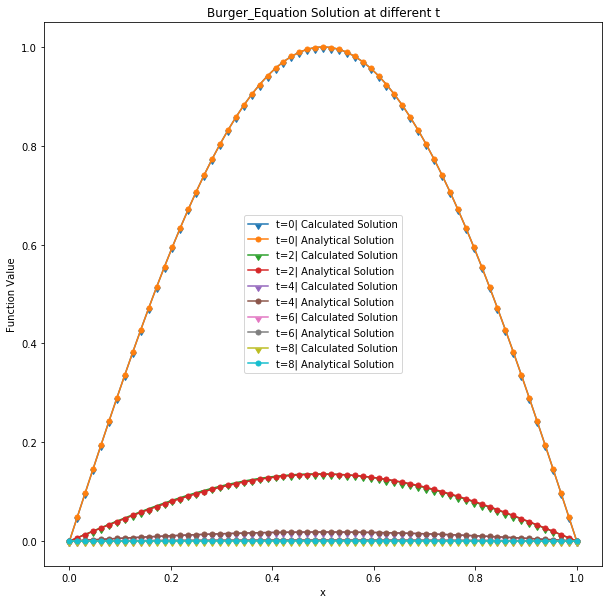

In [26]:
# Time_Index element = [First_value,second_value], where first value is the index where t=second_value occur in Solution C
Time_index = [[i*(C_Burger_Equation.shape[0]/4),(i)*2] for i in range(5)]  
Time_index[-1][0] = Time_index[-1][0]-1
PLOT(Time_index,C_Burger_Equation,Analytical_Burgers_Equation_solution,"Burger_Equation","Burger_Equation Solution at different t")

## Problem 3

In [27]:
def AllenChan_assemble_b(N,c):
    """
    INPUT:
    N :  Number of Nodes
    c :  coefficent at time step n-1 
    Output:
    return vector b
    
    """
    #Holder for vector b
    b = np.zeros((N,1))
    # Get Geometry
    x_coord,Nodes,Quad_Point,Quad_weight = geometry(N)
    
    #Iterate over all interval
    for I in range(N):
        Bases  = Nodes[I][1:]               #Get Basis for given interval
        x_l    = Quad_Point[I]              #Get Quad Point given interval
        w_l    = Quad_weight[I]             #Get Weight for given interval
          
        UnMinusOne = 0
        #Iterate over Bases
        for i in Bases:
            if(i!=N):
                UnMinusOne = UnMinusOne + c[i]*pw_linear_basis_function(x_l,i,x_coord)[0]
        #Iterate over Bases
        for i in Bases:
            if(i!=N):
                b[i] = b[i] + np.power(UnMinusOne,3)*pw_linear_basis_function(x_l,i,x_coord)[0]*w_l
    return b[1:N]    

In [28]:
def AllenChan_Solver(N,Boundary_Condition,dt,T,q,p,alpha):
    
    """
    INPUT:
    N :  Number of Nodes
    f :  Function handel for f(x)
    Boundary_Condition : Function handel for boundary condition
    dt : dt
    T : Total time
    q,p: Function handel for q,p(The value of function for q,p=1 for this lab).
    alpha : alpha
    Output:
    return: Solution, the coefficent C at different t.
    
    """
    
    # Setup geometry
    x_coord,Nodes,Quad_Point,Quad_weight = geometry(N)
 
    # Get M and S
    M,S = system_assembly(N,q,p)
    #Get Matrix C
    
    #Set Matrix C
    Nt = int(T/dt)
    C = np.zeros((Nt+1,N+1))
    C[0,1:-1] = Boundary_Condition(np.array(x_coord[1:-1]))   #Assign initial Conditon
    
    #Holder for vector F
    F = np.zeros((N-1,1))
    
    n=1
    while(n*dt<=T):
        b = AllenChan_assemble_b(N,C[n-1,:])              # Get vector b
        A = ((1-dt)*M + np.power(alpha,2)*dt*S)           # L.H.S of AX=B
        B = np.dot(M,C[n-1,1:-1].reshape(-1,1)) - dt*b    # R.H.S of AX=B
        C[n,1:-1] = np.linalg.solve(A,B).T                # Solve the linear system 
        n = n + 1
    return C                                              

In [29]:
dt = 0.1
T = 20
N = 512      #Setup param for Allen-Chan Equation

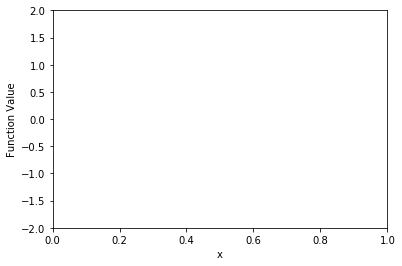

In [30]:
alpha = 0.1
C_alpha_1 = AllenChan_Solver(N,Boundary_Condition_2,dt,T,q,p,alpha)
# Create the animation for result
xlim = [0,1]
ylim = [-2,2]
anim = Animation(C_alpha_1,xlim,ylim)
HTML(anim.to_html5_video())

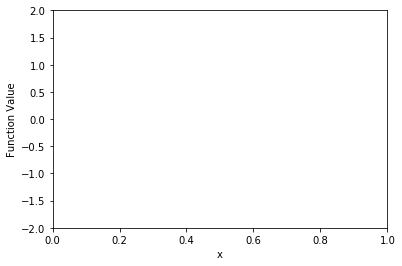

In [31]:
alpha = 0.01
C_alpha_2 = AllenChan_Solver(N,Boundary_Condition_2,dt,T,q,p,alpha)
xlim = [0,1]
ylim = [-2,2]
anim = Animation(C_alpha_2,xlim,ylim)
HTML(anim.to_html5_video())

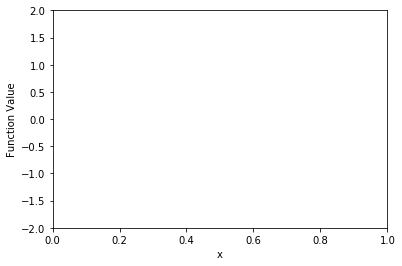

In [32]:
alpha = 0.001
C_alpha_3 = AllenChan_Solver(N,Boundary_Condition_2,dt,T,q,p,alpha)
xlim = [0,1]
ylim = [-2,2]
anim = Animation(C_alpha_3,xlim,ylim)
HTML(anim.to_html5_video())

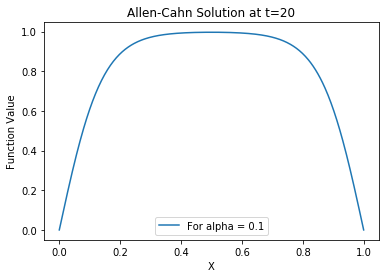

In [39]:
x = np.linspace(0,1,C_alpha_1.shape[1])
plt.plot(x,C_alpha_1[-1,:],label = "For alpha = 0.1")
plt.xlabel("X")
plt.ylabel("Function Value")
plt.legend()
plt.title("Allen-Cahn Solution at t=20")
plt.savefig("ALPHA_1")

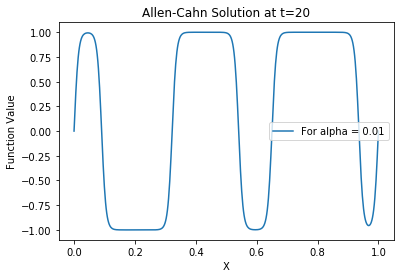

In [40]:
x = np.linspace(0,1,C_alpha_2.shape[1])
plt.plot(x,C_alpha_2[-1,:],label = "For alpha = 0.01")
plt.xlabel("X")
plt.ylabel("Function Value")
plt.legend()
plt.title("Allen-Cahn Solution at t=20")
plt.savefig("ALPHA_2")

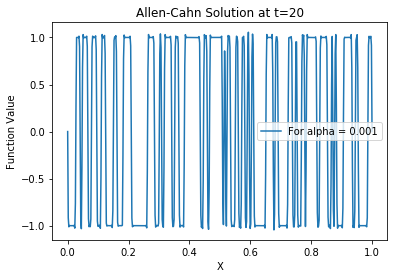

In [42]:
x = np.linspace(0,1,C_alpha_3.shape[1])
plt.plot(x,C_alpha_3[-1,:],label = "For alpha = 0.001")
plt.xlabel("X")
plt.ylabel("Function Value")
plt.legend()
plt.title("Allen-Cahn Solution at t=20")
plt.savefig("ALPHA_3")